In [26]:
# Importing Modules
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data
import matplotlib.pyplot as plt
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, utils, backend as K
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import pmdarima as pm
import statsmodels.api as sm

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Importing SVI Data & Renaming
aex = pd.read_csv(r"/content/drive/MyDrive/AEX_5years_new.csv")
aex = aex.rename(columns={'AEX: (Wereldwijd)': 'AEX SVI'})
amx = pd.read_csv(r"/content/drive/MyDrive/AMX_5years_new.csv")
amx = amx.rename(columns={'AMX Index: (Wereldwijd)': 'AMX SVI'})
dfaex = pd.DataFrame(aex)
dfamx = pd.DataFrame(amx)

# Renaming Columns 
dfaex = dfaex.rename(columns={'Week': 'Date'})
dfaex['Date'] = pd.to_datetime(dfaex['Date'])
dfaex = dfaex.set_index('Date')

dfamx = dfamx.rename(columns={'Week': 'Date'})
dfamx['Date'] = pd.to_datetime(dfamx['Date'])
dfamx = dfamx.set_index('Date')

# Pulling Yahoo Finance Data
# Defining tickers & dates
ticker_aex = ['^AEX']
ticker_amx = ['^AMX']
start_date = '2015-01-01'
end_date = '2019-12-28'

# Downloading & transforming data to weekly data machting SVI
yfaex = yf.download(ticker_aex, start_date, end_date)
yfaex = yfaex.asfreq('W-FRI', method='pad') 
yfaex = pd.DataFrame(yfaex)

yfamx = yf.download(ticker_amx, start_date, end_date)
yfamx = yfamx.asfreq('W-FRI', method='pad') 
yfamx = pd.DataFrame(yfamx)

# Merging Datasets
df = pd.merge(dfaex, yfaex, left_index=True, right_index=True, how='outer')
dfamx = pd.merge(dfamx, yfamx, left_index=True, right_index=True, how='outer')
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AEX SVI,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2015-01-02,40,425.890015,428.089996,420.350006,422.279999,422.279999,53349500
2015-01-09,37,422.410004,424.230011,412.760010,415.589996,415.589996,96722800
2015-01-16,46,423.369995,433.619995,422.940002,432.980011,432.980011,149963200
2015-01-23,47,451.019989,457.100006,450.279999,454.559998,454.559998,154310000
2015-01-30,39,454.000000,454.649994,448.899994,450.390015,450.390015,125282400
...,...,...,...,...,...,...,...
2019-11-29,77,595.669983,600.679993,595.419983,597.289978,597.289978,48913700
2019-12-06,78,594.039978,603.030029,593.750000,602.299988,602.299988,57015000
2019-12-13,81,605.909973,607.580017,601.500000,602.859985,602.859985,99516400


In [27]:
# Defining columns
columns = ['Open', 'AEX SVI']
maindf = df[columns]
maindf

# Checking for missing values
def show_na(df):
    na_df = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    na_df.columns=['count', '%']
    na_df.sort_values(by='count', ascending = False)
    return na_df

# Use the function
show_na(maindf)

,count,%
Open,0,0.0
AEX SVI,0,0.0


Text(0.5, 0, 'Date')

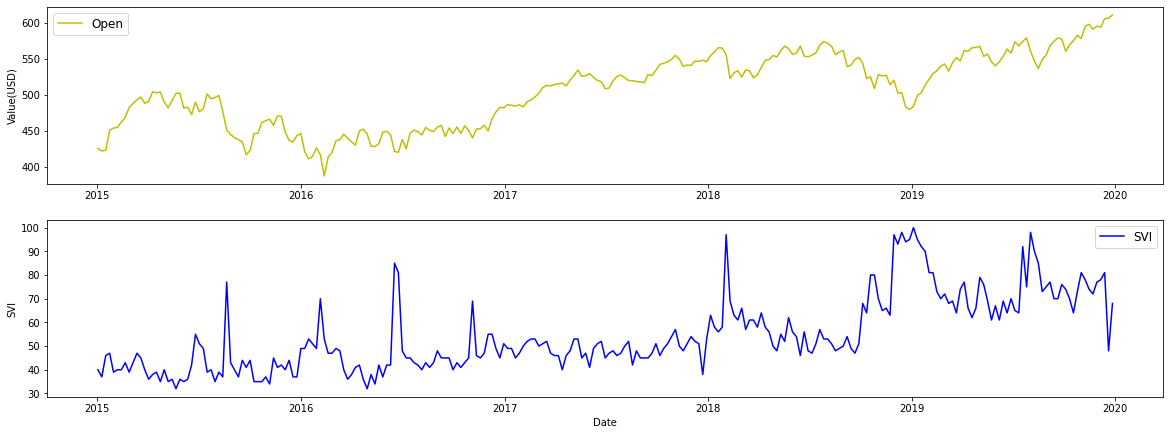

In [28]:
# No missing values, we can go on with plotting
# Plotting AEX and SVI
plt.figure(figsize=(20,15))
plt.subplot(411)
plt.plot(maindf['Open'], label='Open', color='y')
plt.legend(loc='best', fontsize='large')
plt.ylabel('Value(USD)')
plt.subplot(412)
plt.plot(maindf['AEX SVI'], label='SVI', color='b')
plt.legend(loc='best', fontsize='large')
plt.ylabel('SVI')
plt.xlabel('Date')

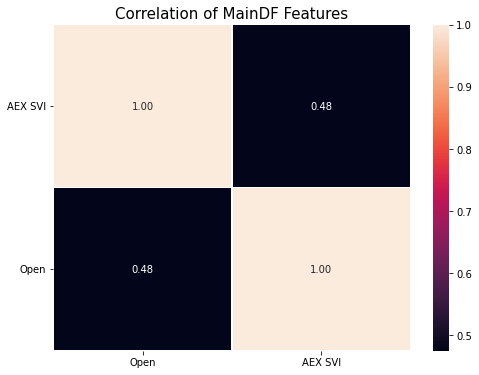

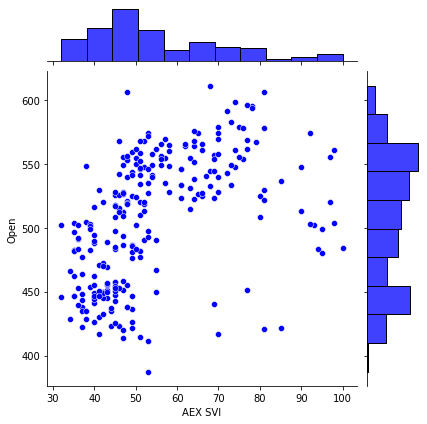

In [29]:
# Checking Correlation between variables
corr = maindf.corr()
plt.figure(figsize = (8,6))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, fmt='.2f', linewidths=.30)
plt.title('Correlation of MainDF Features', y =1.05,  size=15)
pos, textvals = plt.yticks()
plt.yticks(pos,('AEX SVI','Open'), 
    rotation=0, fontsize="10", va="center")

sns.jointplot(x=maindf['AEX SVI'], y=maindf['Open'], color='blue')

In [30]:
# No significant correlation between variables
# Additional formatting
aex = maindf['Open']
svi = maindf['AEX SVI']

# Train-test split
n_obs=21
X_train, X_test = maindf[0:-n_obs], maindf[-n_obs:]
X_train_transformed = X_train.diff().dropna()

# ADF Test
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
print('Augmented Dickey-Fuller Test: Opening Price')
augmented_dickey_fuller_statistics(X_train['Open'])
print('Augmented Dickey-Fuller Test: SVI')
augmented_dickey_fuller_statistics(X_train['AEX SVI'])

Augmented Dickey-Fuller Test: Opening Price
ADF Statistic: -1.761002
p-value: 0.399987
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Augmented Dickey-Fuller Test: SVI
ADF Statistic: -1.896817
p-value: 0.333560
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


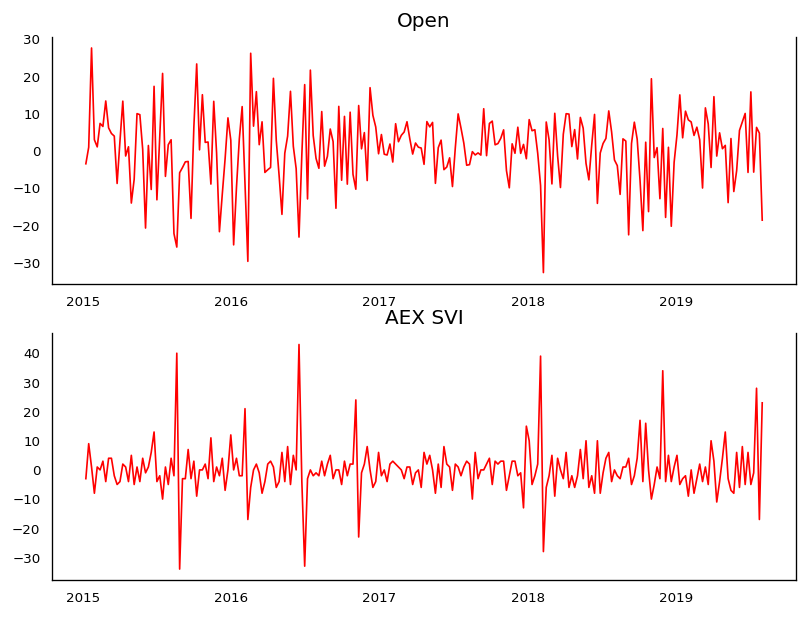

In [31]:
# lets look at each of them displayed out to see that they are stationary
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(8,6))
for i, ax in enumerate(axes.flatten()):
    d = X_train_transformed[X_train.columns[i]]
    ax.plot(d, color='red', linewidth=1)
    ax.set_title(X_train.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=8)
plt.show();

In [32]:
def RMSEfromResid(X):
    summ = 0
    for i in X:
        summ+=i**2
    return((summ/len(X))**0.5)

#ARIMA Models selection - NO SVI
date = maindf.index
X = maindf['Open']
size = int(len(X)*0.9)
train, test = X[0:size], X[size:len(X)]
date_test = date[size:]
def evaluate_arima_model(X, model_order):
    model_arima = ARIMA(X, order=model_order).fit()
    AIC = model_arima.aic
    BIC = model_arima.bic
    LLF = model_arima.llf
    RMSE = RMSEfromResid(model_arima.resid)
    return([AIC, BIC, LLF, RMSE])

import warnings
warnings.filterwarnings("ignore")
# evaluate combinations of p, d and q values for an ARIMA model
p_values = [0,1,2,3]
d_values = [1]
q_values = [0,1,2]
data = list()
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                [AIC, BIC, LLF, RMSE] = evaluate_arima_model(train, order)
                data.append([order,AIC, BIC, LLF, RMSE])
            except:
                continue

ARIMA_Models = pd.DataFrame(data,columns=['ARIMA', 'AIC', 'BIC', 'Maximum Log-Likelihood', 'RMSE'],dtype=float)
evaluate_arima_model(X, order)
ARIMA_Models.sort_values(by=['RMSE'])

,ARIMA,AIC,BIC,Maximum Log-Likelihood,RMSE
8,"(2, 1, 2)",1723.778746,1741.033938,-856.889373,29.435247
11,"(3, 1, 2)",1733.133840,1753.840071,-860.566920,29.483720
10,"(3, 1, 1)",1731.138555,1748.393747,-860.569278,29.483752
9,"(3, 1, 0)",1729.790778,1743.594932,-860.895389,29.488150
5,"(1, 1, 2)",1730.899312,1744.703466,-861.449656,29.495605
4,"(1, 1, 1)",1728.987995,1739.341111,-861.493998,29.496214
7,"(2, 1, 1)",1731.295045,1745.099199,-861.647522,29.498227
6,"(2, 1, 0)",1729.710626,1740.063741,-861.855313,29.501093
2,"(0, 1, 2)",1729.725882,1740.078998,-861.862941,29.501200
1,"(0, 1, 1)",1727.937984,1734.840061,-861.968992,29.502680


In [33]:
#ARIMA Prediction
history = [x for x in train]
predictions = list()
data=list()

len_test= len(test)
for t in range(len_test):
    model_arima = ARIMA(endog = history, order=(2, 1, 2)).fit()
    output = model_arima.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    data.append([date_test[t], obs, yhat])
    
RMSE = (mean_squared_error(test, predictions))**0.5
arima_results = pd.DataFrame(data,columns=['Period','Actual Price', 'Predicted Price'],dtype=float)
print('RMSE without SVI: %.3f' % RMSE)

from sklearn.metrics import mean_absolute_error as mae
rmse = np.sqrt(np.mean(((predictions - test) ** 2)))
print(f'RMSE ARIMA: {rmse}')
error = mae(test, predictions)
print(f'MAE ARIMA: {error}')

RMSE without SVI: 9.899
RMSE ARIMA: 9.899025096398693
MAE ARIMA: 8.359121243869216


In [34]:
df = arima_results
df['Actual_Price'] = df['Actual Price'].diff()
df['Actual_Price'] = df['Actual_Price'].apply(lambda x: 'increase' if x > 0 else 'decrease')

# Create a new column that indicates whether the predicted value increased or decreased
df['Predicted_Price'] = df['Predicted Price'].diff()
df['Predicted_Price'] = df['Predicted_Price'].apply(lambda x: 'increase' if x > 0 else 'decrease')

# Calculate the hit ratio
hit_ratio = (df['Actual_Price'] == df['Predicted_Price']).mean()

print(f'Hit ratio: {hit_ratio:.2f}')

Hit ratio: 0.76


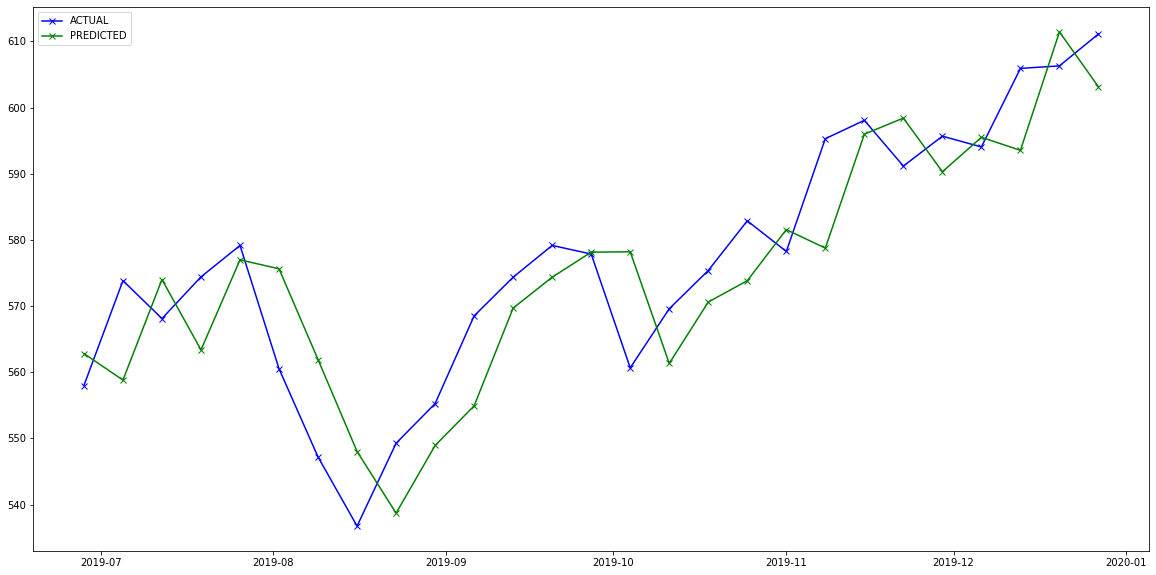

In [ ]:
# Plotting 
plt.rcParams['figure.figsize'] = (20,10)
plt.plot(date_test, test, color='Blue', label='ACTUAL', marker='x')
plt.plot(date_test, predictions, color='green', label='PREDICTED', marker='x')
plt.legend(loc='upper left')
plt.show()
arimax_pred = predictions
arimax_RMSE = RMSE

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_test, y=test, mode='lines+markers', marker=dict(size=4),  name='Actual', marker_color='#39304A'))
fig.add_trace(go.Scatter(x=date_test, y=predictions, mode='lines+markers', marker=dict(size=4), name='Predicted', marker_color='#FFAA00'))
fig.update_layout(legend_orientation="h",
              legend=dict(x=.5, xanchor="center"),
              plot_bgcolor='#FFFFFF',  
              xaxis=dict(gridcolor = 'lightgrey'),
              yaxis=dict(gridcolor = 'lightgrey'),    
              title_text = 'AEX Arima data', title_x = 0.5,
              xaxis_title="Timestep",
              yaxis_title="Stock price",
              margin=dict(l=0, r=0, t=30, b=0))
fig.show()

**ARIMAX - With SVI**

In [35]:
# Train-Test-Split:
date = maindf.index
aexx = maindf['Open']
svi_ex = maindf['AEX SVI']
m = len(aexx)
size = int(len(aexx)*0.9)
train, test = aexx[0:size], aexx[size:m]
ex_train, ex_test = svi_ex[0:size], svi_ex[size:m]
date_test = date[size:]

# Auto-ARIMAX
def evaluate_arimax_model(y, X, model_order):
    model_arimax = ARIMA(endog = y, exog=X, order=model_order).fit()
    AIC = model_arimax.aic
    BIC = model_arimax.bic
    LLF = model_arimax.llf
    RMSE = RMSEfromResid(model_arimax.resid)
    return([AIC, BIC, LLF, RMSE])

warnings.filterwarnings("ignore")
p_values = [0,1,2,3]
d_values = [1]
q_values = [0,1,2]
data = list()
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                [AIC, BIC, LLF, RMSE] = evaluate_arimax_model(train, ex_train, order)
                data.append([order,AIC, BIC, LLF, RMSE])
            except:
                continue

ARIMAX_Models = pd.DataFrame(data,columns=['ARIMAX', 'AIC', 'BIC', 'Maximum Log-Likelihood', 'RMSE'],dtype=float)

evaluate_arimax_model(train, ex_train, order)
ARIMAX_Models.sort_values(by=['RMSE'])

,ARIMAX,AIC,BIC,Maximum Log-Likelihood,RMSE
0,"(0, 1, 0)",1723.220507,1730.122584,-859.610254,29.874082
4,"(1, 1, 1)",1726.222714,1740.026868,-859.111357,29.875932
7,"(2, 1, 1)",1728.194482,1745.449674,-859.097241,29.883021
2,"(0, 1, 2)",1726.921642,1740.725796,-859.460821,29.893440
6,"(2, 1, 0)",1726.952561,1740.756715,-859.476281,29.893991
3,"(1, 1, 0)",1724.965429,1735.318545,-859.482715,29.897271
1,"(0, 1, 1)",1724.959632,1735.312747,-859.479816,29.897372
10,"(3, 1, 1)",1727.484883,1748.191114,-857.742441,29.912200
11,"(3, 1, 2)",1729.464953,1753.622222,-857.732476,29.914665
9,"(3, 1, 0)",1726.197607,1743.452799,-858.098804,29.916611


In [36]:
# Prediction
history = [x for x in train]
his_u = ex_train
predictions = list()
data=list()
test_index = list()
for t in range(len(ex_test)):
    model_arimax = ARIMA(endog = history,exog=his_u, order=(0, 1, 0)).fit()
    output = model_arimax.forecast(steps=1, exog=ex_test.iloc[[t]])
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    test_index.append(t)
    his_u = ex_train.append(ex_test.iloc[test_index])
    data.append([date_test[t], test[t], yhat])


RMSE = (mean_squared_error(test, predictions))**0.5
arima_results = pd.DataFrame(data,columns=['Period','Actual Price', 'Predicted Price'],dtype=float)
print('RMSE with SVI: %.3f' % RMSE)

from sklearn.metrics import mean_absolute_error as mae
rmse = np.sqrt(np.mean(((predictions - test) ** 2)))
print(f'RMSE ARIMAX: {rmse}')
error = mae(test, predictions)
print(f'MAE ARIMAX: {error}')

RMSE with SVI: 9.545
RMSE ARIMAX: 9.544653647979048
MAE ARIMAX: 8.200733418016588


In [37]:
df = arima_results
df['Actual_Price'] = df['Actual Price'].diff()
df['Actual_Price'] = df['Actual_Price'].apply(lambda x: 'increase' if x > 0 else 'decrease')

# Create a new column that indicates whether the predicted value increased or decreased
df['Predicted_Price'] = df['Predicted Price'].diff()
df['Predicted_Price'] = df['Predicted_Price'].apply(lambda x: 'increase' if x > 0 else 'decrease')

# Calculate the hit ratio
hit_ratio = (df['Actual_Price'] == df['Predicted_Price']).mean() 

print(f'Hit ratio: {hit_ratio:.2f}')

Hit ratio: 0.78


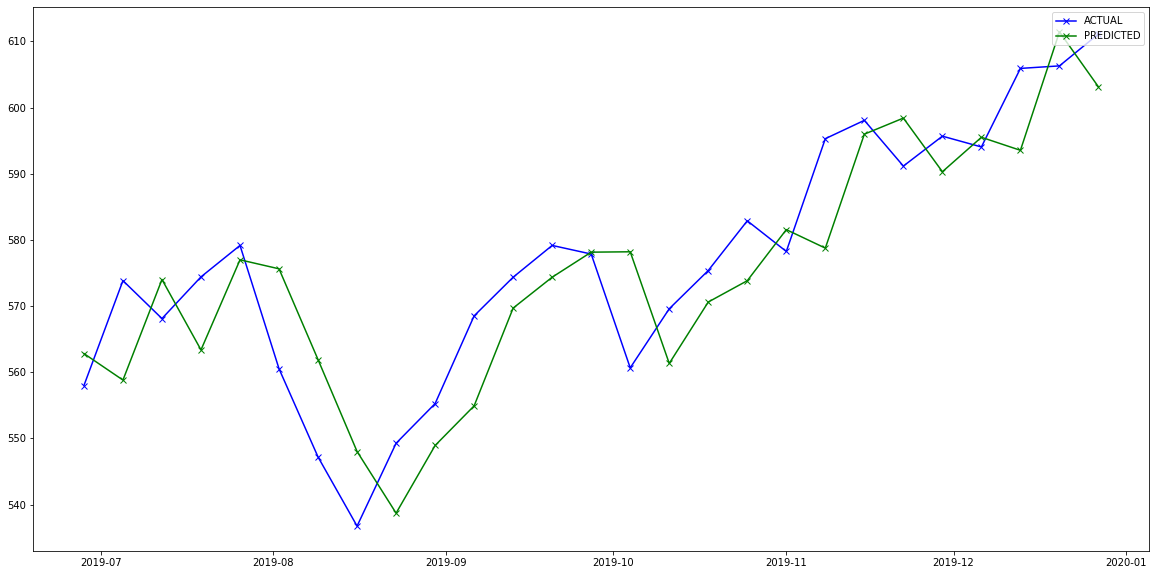

In [ ]:
# plot our calculations above to compare prediction to actual trend
plt.rcParams['figure.figsize'] = (20,10)
plt.plot(date_test[0:], test, color='Blue', label='ACTUAL', marker='x')
plt.plot(date_test[0:], predictions, color='green', label='PREDICTED', marker='x')
plt.legend(loc='upper right')
plt.show()
arimax_pred = predictions
arimax_RMSE = RMSE

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_test, y=test, mode='lines+markers', marker=dict(size=4),  name='Actual', marker_color='#39304A'))
fig.add_trace(go.Scatter(x=date_test, y=predictions, mode='lines+markers', marker=dict(size=4), name='Predicted', marker_color='#FFAA00'))
fig.update_layout(legend_orientation="h",
              legend=dict(x=.5, xanchor="center"),
              plot_bgcolor='#FFFFFF',  
              xaxis=dict(gridcolor = 'lightgrey'),
              yaxis=dict(gridcolor = 'lightgrey'),    
              title_text = 'AEX ARIMAX data', title_x = 0.5,
              xaxis_title="Timestep",
              yaxis_title="Stock price",
              margin=dict(l=0, r=0, t=30, b=0))
fig.show()